# Eigen Faces

---


<b><div style="text-align: right">[TOTAL POINTS: 100]</div></b>

In this assignment you will learn to generate new human faces by using the concept of SVD from linear algebra. An image is defined by a collection of pixel values defined for each discrete point in a 2D plane. Human faces are alike(i.e. they have eyes, hair, nose, lips etc.) and can thus be decomposed into a number of distinct components. 
If we add these different components in different ratios we can generate various of faces. This assignment manipulates this fact to first decompose the images to generate its components using SVD. We then choose the top `n` components with greatest singular values. These are the components which include the most variance and rejecting the smaller components should do little harm to the quality of image. By only storing the top `n` components we can regenerate the whole set of images with little loss of information. 

This characteristic of SVD can be used in compressing images. Interesting, right? Let's start coding.

## Dataset Description
**Source:** https://susanqq.github.io/UTKFace/

UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with only one face in each image which are labelled by age, gender, and ethnicity. The dataset also provides correspondingly aligned and cropped faces and corresponding landmarks. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization, etc.


In [1]:
!wget -O utk_subset.zip 'https://storage.googleapis.com/codehub-data/6-P-2-UTKFaces-Subset.zip'
import sys
from zipfile import PyZipFile
pzf = PyZipFile('utk_subset.zip')
pzf.extractall()
# Dataset is now at the directory 'UTKsubset'

--2021-06-16 15:07:46--  https://storage.googleapis.com/codehub-data/6-P-2-UTKFaces-Subset.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3268426 (3.1M) [application/x-zip-compressed]
Saving to: ‘utk_subset.zip’

utk_subset.zip      100%[===================>]   3.12M  --.-KB/s    in 0.03s   

2021-06-16 15:07:51 (95.4 MB/s) - ‘utk_subset.zip’ saved [3268426/3268426]



### Import libraries

First, we will import the required libraries. We will need the help of four main libraries, namely, `numpy`, `os`,`PIL` and `matplotlib`. By now, you should be familiar with those libraries.

In [2]:
import numpy as np # for numerical manipulation and linear algebra
import PIL.Image as Image   # for opening, resizing and filtering images
import matplotlib.pyplot as plt # for plotting images
import os # for walking through directories
import random

### Prepare dataset
Dataset has been downloaded and unzipped into folder `crop_part1`. In this section, we will use the `os.walk` function to walk through all the directories and files of the extracted folder and collect the path to all the files having '.jpg' extension.

Then, we will load $500$ gray scale form of images of size $64\times 64$ into a numpy array using `PIL` library to open, resize and convert the images to gray scale form. 

In [3]:
data_paths = [] # array for storing image paths
labels = [] # array for storing image names

def parse_gender(file_name):
    return int(file_name.split('_')[1])
for image_file_name in os.listdir('UTKsubset'):
    
    data_paths.append(os.path.join('UTKsubset', image_file_name))
    labels.append(parse_gender(image_file_name))
    
temp = list(zip(data_paths, labels))
random.shuffle(temp)
data_paths, labels = zip(*temp)

In [4]:
height, width = 64 , 64 # designate the height and width to resize the images to
NUM_IMAGES_TRAIN = 500  # define the number of images to train with 
NUM_IMAGES_TEST = 100  # define the number of images to test with

train_images_paths = data_paths[:NUM_IMAGES_TRAIN]
test_images_paths = data_paths[-NUM_IMAGES_TEST:]
train_labels = labels[:NUM_IMAGES_TRAIN]
test_labels = labels[-NUM_IMAGES_TEST:]


(500, 64, 64)


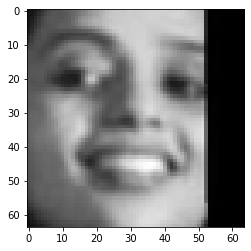

In [5]:
train_images = []
for image_path in train_images_paths:
    image = Image.open(image_path).resize((height,width),Image.BICUBIC).convert('L')
    train_images.append(np.array(image))
train_images = np.array(train_images)

test_images = []
for image_path in test_images_paths:
    image = Image.open(image_path).resize((height,width),Image.BICUBIC).convert('L')
    test_images.append(np.array(image))
test_images = np.array(test_images)

# test if the dataset has desired shape and show one image in the dataset
plt.imshow(train_images[0],cmap='gray') # show the first image
print(train_images.shape)

### Compute mean faces and centered dataset

Now, we will compute the **mean** face. The mean face is the face image whose pixel values are the average of all the pixel values in the dataset. We will then subtract the mean face from all the images in the dataset to get the mean to $0$.   

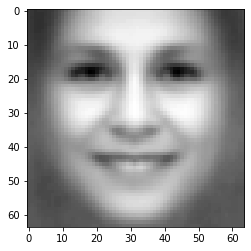

In [6]:
mean_face = train_images.mean(axis=0).astype(np.uint8) #compute the mean face
plt.imshow(mean_face, cmap="gray") # plot the face

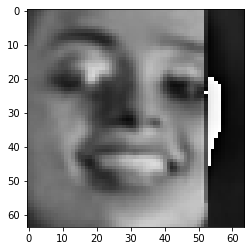

In [7]:
dataset_centered = np.int8(train_images - mean_face)
plt.imshow(dataset_centered[0],cmap="gray") # plot an image from the centered dataset

### Exercise 1: Decompose the data into components
<b><div style="text-align: right">[POINTS: 25]</div></b>

Finally, it is your time to code. You will now write a function to decompose an image into components using Singular Value Decomposition. You can refer to the reading material to review the concept of SVD. In this assignment, we will use two terminologies to refer to the results of SVD. We know,
$$
A = U \Sigma V^T
$$
Here, the columns of $U \Sigma$ are referred to as `projections` and the rows of $V^T$ are referred to as `components`.

**Task:** 
- Define the function `get_components`
- It takes `centered_dataset` and  `num_components` as arguments
- It returns the top `num_components` rows of `components` matrix 

In [8]:
def get_components(centered_dataset, num_components):
    U, S, Vt = np.linalg.svd(centered_dataset) # calculate the SVD of centered_dataset
    components = np.array([Vt[num_components-1]]) # select the top num_components components
    return components

In [9]:
assert np.array_equal(get_components(np.asarray([[1,0,0],[0,1,0]]), 1),[[1., 0., 0.]])

### Exercise 2: Project the centered faces to the eigen space

<b><div style="text-align: right">[POINTS: 25]</div></b>

You have the components, which form a basis for the eigen space of the faces. Project the faces to this space using the vectors in this basis. Remember that the length of projection of a column vector $\vec{a}$ to another column vector $\vec{b}$ is given by $\vec{a}^T\vec{b}$ when b is a unit vector. This means that the lengths of projections of $\vec{a}$ into a new set of unit basis vectors arranged in a matrix $C$ is given by $\vec{a}^TC$.

* Define a function `project` that takes in the arguments `vectors` and `basis`.
* `project` should return the projection of vectors in `vectors` into the space spanned by the vectors in `basis`.

In [39]:
def project(vectors, basis):
    return  np.dot(vectors, basis.T) 

In [40]:
assert np.array_equal(project(np.asarray([[1,0,0],[0,1,0]]), np.asarray([[1,0,1],[0,1,1]])),[[1, 0],[0, 1]])


### Exercise 3: Reconstruct faces using the eigenfaces

<b><div style="text-align: right">[POINTS: 20]</div></b>

Reconstruct a face from back to the image space. Then, reshape this reconstructed vector to be of same shape as `mean_image`, and then add the `mean_image`.

In [12]:
def reconstruct(projection, components, mean_image):
    
    # backproject projection to the original image space
    reconstructed_vector = projection @ components  
    
    # reshape the vector from above to be of same shape 
    # as mean_image and add the mean image to it
    reconstructed_image = mean_image + reconstructed_vector.reshape(mean_image.shape)
    
    return reconstructed_image

# YOUR CODE HERE
# raise NotImplementedError()


In [13]:
assert np.array_equal(reconstruct(np.asarray([[1, 0],[0, 1]]),
                                  np.asarray([[1, 0, 0],[0, 1, 0]]),
                                  np.asarray([[0.5,0.5,0.5],[0.5,0.5,0.5]])),
                                  [[1.5, 0.5, 0.5],[0.5, 1.5, 0.5]])


### Bringing it all together

Your solutions to the three exercises above can now be brought together to compute the eigenfaces for this dataset. Be sure to experiment with different values of `NUM_COMPONENTS` and see how it affects the quality of reconstructed images. 

In [14]:
NUM_COMPONENTS = 300 # number of principal components to use

In [15]:
components = get_components( # decompose
    dataset_centered.reshape(NUM_IMAGES_TRAIN,height*width), 
    NUM_COMPONENTS
)

In [16]:
# we can now project images from the test set
# into the space formed by principal components

# pick a random image from the test set
test_face = test_images[np.random.randint(0,NUM_IMAGES_TEST)]

# center the test_face at the mean face
test_face_centered = np.int8(test_face - mean_face)

# project the images to the principal components
test_projection = project(test_face_centered.reshape(-1, 64*64), components)

In [17]:
test_reconstruction = reconstruct(test_projection, components, mean_face)

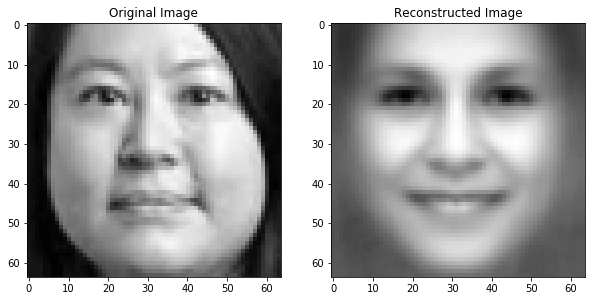

In [18]:
f, axarr = plt.subplots(1,2, figsize=(10,6))
axarr[0].imshow(test_face, cmap='gray')
axarr[0].title.set_text('Original Image')
axarr[1].imshow(test_reconstruction, cmap='gray')
axarr[1].title.set_text('Reconstructed Image')
plt.show()

### Exercise 4: Predicting the gender

<b><div style="text-align: right">[POINTS: 30]</div></b>

In this task, you will be implementing a simple linear regression model and using it to predict the gender of the person based on the provided image. The training data, training labels, test data and test labels are provided to you. We can formulate the problem as follows:

$A. w = B$

where $A$ is a $(n\times d)$ matrix of training image projections. Each image projection obtained from above tasks are arranged as rows of matrix $A$. Similarly, $B$ is a $(n \times 1)$ matrix where each row gives the label of the corresponding image. We use label: 100 for females and label: -100 for males.

Your task will be to learn the elements in the $w$ matrix which map the image projections to their corresponding labels. Do this by using the Least Squares Solution of Linear Equation you have previously learnt.

* Give the definition for the function `learn_weights` that takes in the arguments `training_data` and `labels`.
 `learn_weights` should return the weight matrix $w$ defined as a $(d \times d)$ matrix.

* Also give the definition for the function `predict_results` that takes in the arguments `test_data` and `weights`and returns the prediction labels for the test image projections provided as a $(n \times d)$ matrix similar to the train image projections. You should generate the prediction labels based on the equation given above.

In [29]:
def learn_weights(training_data, labels):
    weights = None
    # YOUR CODE HERE
    return weights
def predict_results(test_data, weights):
    predictions = None
    # YOUR CODE HERE
    predictions = test_data @ weights
    return predictions

train_projections = project(train_images.reshape(-1,height*width),components)
train_labels = np.array(train_labels)*200 - 100
weights = learn_weights(train_projections,train_labels)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 500 is different from 1)

In [30]:
np.testing.assert_array_almost_equal(
    learn_weights(
        np.asarray([[1,0.5],[0.5,1],[0.5, 1]]),
        np.asarray([0,1,5])
    ), 
    np.array([-2, 4])
)
assert np.array_equal(predict_results(np.asarray([0.5,1,1]),np.asarray([0,1,0])),1)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 2)

In [ ]:
def calc_accuracy(predictions, labels):
    return np.sum(np.equal(predictions>0,labels>0))/len(labels)

In [ ]:
train_projections = project(train_images.reshape(-1,height*width),components)
test_projections = project(test_images.reshape(-1,height*width), components)
train_labels = np.array(train_labels)*200 - 100
test_labels = np.array(test_labels)*200 - 100
weights = learn_weights(train_projections,train_labels)
predictions = predict_results(test_projections,weights)
accuracy = calc_accuracy(predictions,test_labels)
print("Overall test set accuracy: ",accuracy)

#visualizing the results in test images
fig, axes = plt.subplots(3,3, figsize=(10,18))


test_predictions = predict_results(test_projections[6:15], weights)
for i in range(3):
    for j in range(3):
        axes[i][j].imshow(test_images[6+i*3+j], cmap='gray')
        label_text = 'Female' if test_labels[6+i*3+j]>0  else 'Male'
        prediction_text = 'Female' if test_predictions[i*3+j]>0 else 'Male'
        axes[i][j].title.set_text('True Label:{}\n Predicted Label:{}'.format(label_text,prediction_text))
plt.show()